In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [3]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

## Network

### Topology

In [4]:

two_node = False
three_node = False
ten_ring = False
watts_strogatz = False
geo_pref = False
geo_pref_recip = True

if two_node:
    # Fully connected 2 neuron network
    G = nx.DiGraph()
    G.add_nodes_from([0, 1])
    # G.add_edges_from([(0, 1), (1, 0), (0, 0), (1, 1)])
    G.add_edges_from([(0, 1), (1, 0)])
elif three_node:
    # Fully connected 3 neuron network
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2])
    G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)])
    # G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (0, 0), (1, 1), (2, 2)])
elif ten_ring:
    # Directed ring of 10 neurons, connected to 2 nearest neighbors
    n = 20
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    G.add_edges_from([(i, (i + 1) % n) for i in range(n)])
    G.add_edges_from([(i, (i + 2) % n) for i in range(n)])
    G.add_edges_from([(i, (i - 1) % n) for i in range(n)])
    G.add_edges_from([(i, (i - 2) % n) for i in range(n)])
elif watts_strogatz:
    n = 20
    k = 4  # Each node is connected to k nearest neighbors in ring topology
    p = 0.1  # The probability of rewiring each edge
    G = nx.watts_strogatz_graph(n, k, p)
    G = G.to_directed()
elif geo_pref:
    n_neurons = 500

    G = spatial_pa_directed_var_out(n=n_neurons, box_dim=2, alpha=2.0, pa_gamma=1.0, local_frac=0.7,
                                kout_dist="lognormal", kout_params=(1.8, 0.9), kmin=2, seed=None)
    
    ensure_min_in_out(G)

    # Graph density
    print("Graph density:", nx.density(G))
    # Number of nodes and edges
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
elif geo_pref_recip:
    n_neurons = 500

    G = spatial_pa_directed_var_out_reciprocal(
    n=n_neurons,
    box_dim=3,
    k_out=(3, 10),
    m0=12,
    alpha_dist=9.0,
    attractiveness=1.0,
    reciprocity=0.2,
    reciprocity_local=1.2,
    enforce_min_deg=True,
    seed=None
)

    pos = [np.array([G.nodes[i].get('pos')[0], G.nodes[i].get('pos')[1]]) for i in G.nodes()]

    # Graph density
    print("Graph density:", nx.density(G))
    # Number of nodes and edges
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())

# Small-worldedness of G
# print("Small-worldedness:", smallworld.omega(G.to_undirected(), niter=5, nrand=10))

Graph density: 0.015759519038076153
Number of nodes: 500
Number of edges: 3932


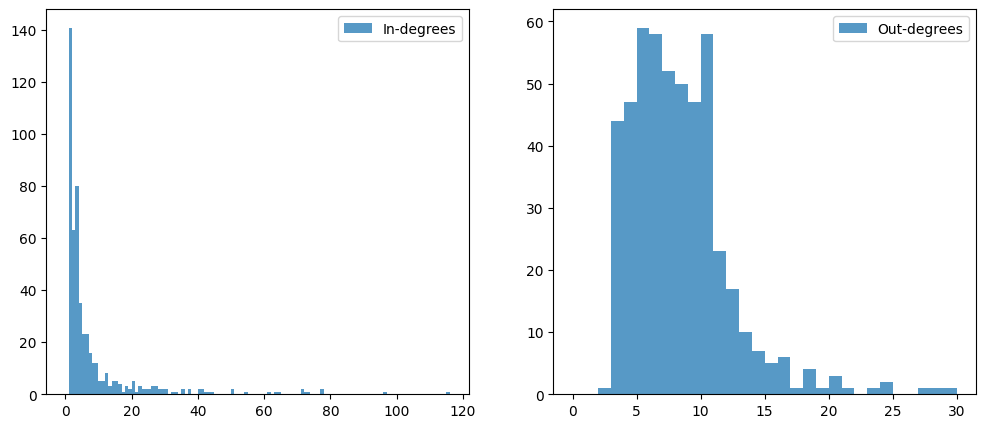

In [5]:
# Histogram of in-degrees and out-degrees
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(max(in_degrees) + 2), alpha=0.75, label='In-degrees')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(max(out_degrees) + 2), alpha=0.75, label='Out-degrees')
plt.legend(loc='upper right')

In [6]:
# Small-worldedness of G
# print("Small-worldedness:", smallworld.omega(G.to_undirected(), niter=2, nrand=4))

In [7]:
G.nodes(data=True)[0]

{'pos': array([0.35429178, 0.75527518, 0.47995719])}

In [8]:
# Plot the network
# Position from "pos" node attribute from G, (x, y) coordinates in numpy array
# pos = [np.array([G.nodes[i].get('pos')[0], G.nodes[i].get('pos')[1]]) for i in G.nodes()]
# plt.figure(figsize=(4, 2))
# nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=350, font_size=16, font_weight='bold', arrowsize=20)
# plt.title("Fully Connected 2 Neuron Network")

### Assign types

In [9]:
# Assign all nodes to ntype ss4
# ntype = 'p23'

# for i in G.nodes:
#     G.nodes[i]['ntype'] = ntype
#     G.nodes[i]['inhibitory'] = False
#     G.nodes[i]['layer'] = 0

dist_result = assign_EI_and_subtypes_with_quotas(G, target_frac_exc=0.7, EXC_quota={"p23": 0.7, "TC": 0.3} , solver="greedy")

dist_result

{'EI_bias_used': 0.8472978603872033,
 'target_frac_exc': 0.7,
 'achieved_frac_exc': 0.614,
 'EXC_counts': {'p23': np.int64(215), 'TC': np.int64(92)},
 'INH_counts': {'TI': np.int64(37),
  'TRN': np.int64(32),
  'b': np.int64(37),
  'nb': np.int64(43),
  'nb1': np.int64(44)},
 'n_exc': 307,
 'n_inh': 193,
 'solver': 'greedy'}

### Weight assignment

In [10]:
G = assign_biological_weights(G, mu_E=-1.2, sigma_E=0.9,
                        mu_I=-0.8, sigma_I=0.6,
                        use_distance=True, lambda_mm=20.0, kernel="exp")

# G = assign_biological_weights(G)

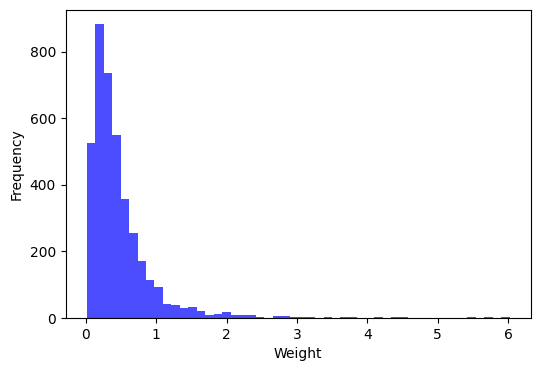

In [11]:
# Plot weight distribution
weights = [G.edges[i]['weight'] for i in G.edges]
plt.figure(figsize=(6, 4))
plt.hist(weights, bins=50, color='blue', alpha=0.7)
# plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

### Final tuning

In [12]:
# for i in G.edges:
#     u, v = i
#     # Euclidean distance between node pos
#     G.edges[i]['distance'] = np.linalg.norm(pos[u] - pos[v])

# Mean distance
mean_distance = np.mean([G.edges[i]['distance'] for i in G.edges])
distance_scale = 5.0


weight_scale_excitatory = 12.0
weight_scale_inhibitory = 6.0

for i in G.edges:
    u, v = i
    # G.edges[i]['weight'] = 11.0
    # Random distance around 1
    # G.edges[i]['distance'] = (1 + 0.3 * (2 * random.random() - 1)) * distance_scale
    # Normalized distance and multiply by distance scale
    G.edges[i]['distance'] = G.edges[i]['distance'] / mean_distance * distance_scale
    G.edges[i]['dendritic'] = False

    # Weight scaling
    if not G.nodes[u]['inhibitory']:
        G.edges[i]['weight'] *= weight_scale_excitatory
    else:
        G.edges[i]['weight'] *= weight_scale_inhibitory


In [13]:
# print(G.nodes(data=True))
# print(G.edges(data=True))

In [14]:
# Plot network with node color based on ntype

plot = False

if plot:

    ntype_colors = {
        "p23": "blue",
        "TC": "green",
        "TI": "red",
        "TRN": "purple",
        "b": "orange",
        "nb": "pink",
        "nb1": "cyan"
    }

    # Extract node colors
    node_colors = [ntype_colors.get(G.nodes[i]['ntype'], 'gray') for i in G.nodes]

    # Extract edge weights (default to 1 if missing)
    weights = [d.get('weight', 1.0) for _, _, d in G.edges(data=True)]

    # Scale edge thickness for visibility (tweak the multiplier as needed)
    min_w, max_w = min(weights), max(weights)
    if max_w > min_w:
        edge_widths = [(1 + 5 * ((w - min_w) / (max_w - min_w)))/5 for w in weights]
    else:
        edge_widths = [2 for _ in weights]  # fallback if all weights are identical

    # Scale node size based on degree
    degrees = [G.degree(n) for n in G.nodes()]
    min_deg, max_deg = min(degrees), max(degrees)
    if max_deg > min_deg:
        node_sizes = [(20 + 80 * ((deg - min_deg) / (max_deg - min_deg))) for deg in degrees]
    else:
        node_sizes = [50 for _ in degrees]  # fallback if all degrees are identical

    # Draw
    plt.figure(figsize=(8, 5))
    nx.draw(
        G, pos,
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        font_size=6,
        font_weight='bold',
        arrowsize=4,
        width=edge_widths
    )
    plt.title("Network with Neuron Types and Weighted Edges")

    # Legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                label=ntype, markerfacecolor=color, markersize=10)
        for ntype, color in ntype_colors.items()
    ]
    plt.legend(handles=handles, title="Neuron Types",
            bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Simulation

In [15]:
dt = 0.1

In [16]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = ["p23", "TC", "TI", "TRN", "nb1", "b", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True, True, True, True, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [17]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

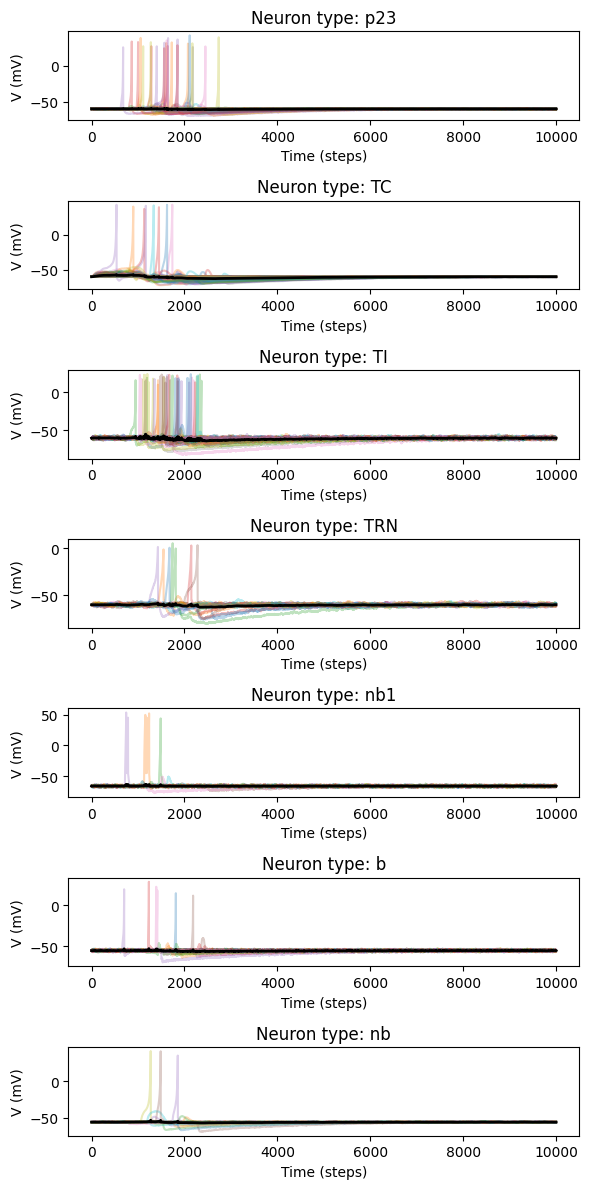

In [18]:
sim = Simulation(connectome, dt, stepper_type="adapt")

I_ext = np.zeros((pop.n_neurons))
I_ext[pop.get_neurons_from_type("TC")] = 150
# I_ext[pop.get_neurons_from_type("TI")] = 50

rate = np.zeros(n_neurons)
rate[pop.get_neurons_from_type("TC")[:len(rate[pop.get_neurons_from_type("TC")])//2]] = 0.3
poisson = PoissonInput(n_neurons, rate, amplitude=1.0)


# I_ext = 100

for i in range(1000):
    sensory_spikes = poisson(dt)
    sim.step(spike_ext=sensory_spikes)
    # sim.step(I_ext=I_ext)

I_ext[:] = 0

for i in range(9000):
    sim.step(I_ext=I_ext)

sim.plot_voltage_per_type(figsize=(6, 12))

In [19]:
sim.stats.compute_metrics(dt, bin_ms_participation=300)

C:\Users\kingt\Dropbox\Programming\NeuralSimV3\NeuroSimV3\python\src\overhead.py:126: RuntimeWarning: invalid value encountered in divide
  fanos = np.where(mu > 0, var / mu, np.nan)


{'rate_mean_Hz': 0.205979402059794,
 'rate_median_Hz': 0.0,
 'rate_p95_Hz': 0.9999000099990001,
 'ISI_CV_median': 0.4959040859860232,
 'refractory_violations_per_neuron': 0.01,
 'Fano_median_300ms': 1.0000000000000002,
 'mean_noise_corr_50ms': 0.018260520976241753,
 'participation_frac_mean_300ms': 0.04533333333333334,
 'participation_frac_median_300ms': 0.0,
 'participation_frac_p95_300ms': 0.1224,
 'participation_frac_total': 0.136,
 'pop_spec_entropy': 7.979800147350845}

In [20]:
connectome.compute_metrics(small_world=False)

KeyboardInterrupt: 

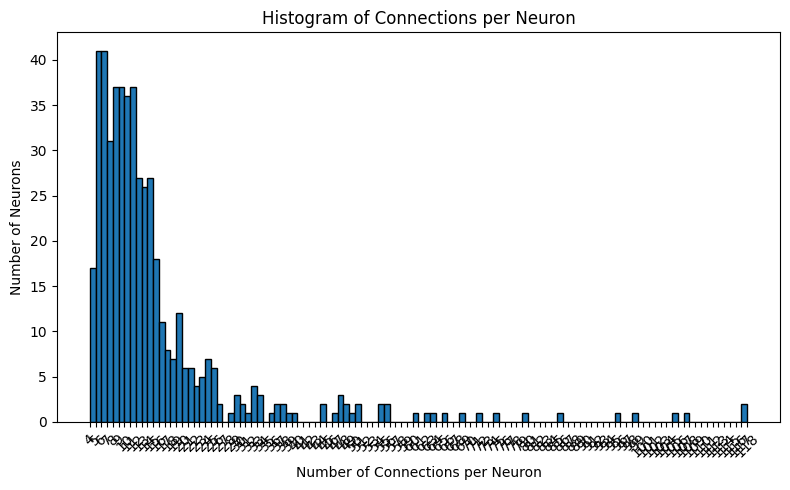

(array([17, 41, 41, 31, 37, 37, 36, 37, 27, 26, 27, 18, 11,  8,  7, 12,  6,
         6,  4,  5,  7,  6,  2,  0,  1,  3,  2,  1,  4,  3,  0,  1,  2,  2,
         1,  1,  0,  0,  0,  0,  2,  0,  1,  3,  2,  1,  2,  0,  0,  0,  2,
         2,  0,  0,  0,  0,  1,  0,  1,  1,  0,  1,  0,  0,  1,  0,  0,  1,
         0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2]),
 array([  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
         15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
         26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
         37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
         59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
         70.,  71.,  72.,  73.,  74.,  75.

In [ ]:
connectome.plot_connections_histogram()